https://forecastegy.com/posts/multi-step-time-series-forecasting-in-python/

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import yfinance as yf
from datetime import datetime
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregDirect import ForecasterAutoregDirect
from sklearn.ensemble import RandomForestRegressor

In [2]:

class ETL:
    """
    ticker: str
    period: string
    test_size: float betwee 0 and 1
    n_input: int
    timestep: int
    Extracts data for stock with ticker `ticker` from yf api,
    splits the data into train and test sets by date,
    reshapes the data into np.array of shape [#weeks, 5, 1],
    converts our problem into supervised learning problem.
    """

    def __init__(self, datainput, test_size=0.2, n_input=5, timestep=5, normalize_bool=False, scaler=None, target_col=None) -> None:
        self.datainput = datainput
        self.test_size = test_size
        self.n_input = n_input
        self.timestep = timestep
        self.normalize_bool = normalize_bool
        self.scaler = scaler
        self.target_col = target_col
        self.df = self.extract_historic_data()
        self.train, self.test = self.etl()
        self.X_train, self.y_train = self.to_supervised(self.train)
        self.X_test, self.y_test = self.to_supervised(self.test)

        if self.normalize_bool:
            print('normalized', normalize_bool)
            self.scaler = scaler
        else:
            print('not normalized', normalize_bool)
            self.scaler = None

    def extract_historic_data(self) -> pd.DataFrame:
        if self.normalize_bool:
            data = self.scaler.fit_transform(self.datainput)
            return pd.DataFrame(data, columns=self.datainput.columns)
        else:
            return self.datainput

    def split_data(self) -> tuple:
        """
        Splits our pd.Series into train and test series with
        test series representing test_size * 100 % of data.
        """
        # data = self.extract_historic_data()
        data = self.df
        if len(data) != 0:
            train_idx = round(len(data) * (1 - self.test_size))
            train = data.iloc[:train_idx]
            test = data.iloc[train_idx:]
            return train, test
        else:
            raise Exception('Data set is empty, cannot split.')

    def window_and_reshape(self, data) -> np.array:
        """
        Reformats data into shape our model needs.
        """
        samples = data.shape[0] // self.timestep
        if samples <= 0:
            raise ValueError(
                "The number of samples is less than or equal to 0. Ensure data length is greater than timestep.")
        result = np.array_split(data[:samples * self.timestep], samples)
        return np.array(result)

    def transform(self, train, test) -> np.array:
        train_remainder = train.shape[0] % self.timestep
        test_remainder = test.shape[0] % self.timestep
        if train_remainder != 0:
            train = train[:-(train_remainder)]
        if test_remainder != 0:
            test = test[:-(test_remainder)]
        # print("train:", train, "test:", test)
        if len(train) < self.timestep or len(test) < self.timestep:
            raise ValueError(
                "Not enough data to form at least one timestep window.")
        train_transformed, test_transformed = self.window_and_reshape(
            train), self.window_and_reshape(test)
        print(f'train_transformed shape: {train_transformed.shape}')
        print(f'test_transformed shape: {test_transformed.shape}')
        return train_transformed, test_transformed

    def etl(self) -> tuple[np.array, np.array]:
        """
        Runs complete ETL
        """
        train, test = self.split_data()
        print("train:", train, "test:", test)
        return self.transform(train, test)

    def to_supervised(self, data, n_out=5) -> tuple:
        X, y = [], []
        for sample in data:
            if len(sample) >= self.n_input + n_out:
                for i in range(len(sample) - self.n_input - n_out + 1):
                    X.append(sample[i:i + self.n_input])
                    y.append(sample[i + self.n_input:i +
                             self.n_input + n_out, :])
        print(len(sample) - self.n_input - n_out + 1)
        X, y = np.array(X), np.array(y)
        print(f'X shape: {X.shape}')
        print(f'y shape: {y.shape}')
        return X, y

In [9]:
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0.2, epsilon=1e-6, attention_axes=None, kernel_size=1):
    x = layers.LayerNormalization(epsilon=epsilon)(inputs)
    attention_output, _ = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout,
        attention_axes=attention_axes
    )(x, x, return_attention_scores=True)
    x = layers.Dropout(dropout)(attention_output)
    res = x + inputs

    # Feed Forward Part
    x = layers.LayerNormalization(epsilon=epsilon)(res)
    x = layers.Conv1D(filters=ff_dim, kernel_size=kernel_size,
                      activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=kernel_size)(x)
    return x + res


def build_transformer(head_size, num_heads, ff_dim, num_trans_blocks, mlp_units, dropout=0.2, mlp_dropout=0.2, attention_axes=None, epsilon=1e-6, kernel_size=1):
    n_timesteps, n_features, n_outputs = 5, 3, 15
    inputs = tf.keras.Input(shape=(n_timesteps, n_features))
    masked_inputs = layers.Masking()(inputs)
    # x = inputs
    x = masked_inputs
    for _ in range(num_trans_blocks):
        x = transformer_encoder(x, head_size=head_size, num_heads=num_heads, ff_dim=ff_dim,
                                dropout=dropout, attention_axes=attention_axes, kernel_size=kernel_size, epsilon=epsilon)
    x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)
    outputs = layers.Dense(n_outputs)(x)
    outputs = layers.Reshape((n_timesteps, n_features))(outputs)
    return tf.keras.Model(inputs, outputs)



def fit_transformer(transformer, x_train, y_train, x_val, y_val, display_loss=False):
    transformer.compile(
        loss="mse",
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
        metrics=["mae", 'mape']
    )

    callbacks = [tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', patience=10, restore_best_weights=True)]

    hist = transformer.fit(x_train, y_train,
                           validation_data=(x_val, y_val),
                           batch_size=32, epochs=25,
                           verbose=1, callbacks=callbacks)

    if display_loss:
        history_df = pd.DataFrame(hist.history)
        history_df['val_loss'].plot()
        plt.title('Validation Loss')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend(['Validation'], loc='upper right')
        plt.show()
        history_df['loss'].plot()
        plt.title('Training Loss')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend(['Train'], loc='upper right')
        plt.show()

        history_df.loc[:, ['mae', 'val_mae']].plot()
        plt.title('Model MAE')
        plt.ylabel('MAE')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Validation'], loc='upper right')
        plt.show()

    return hist

https://thescipub.com/pdf/jcssp.2023.739.748.pdf

In [74]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


class PredictAndForecast:
    def __init__(self, model, train, test, n_input=30) -> None:
        self.model = model
        self.train = train
        self.test = test
        self.n_input = n_input
        # self.predictions = self.get_predictions()

    def forecast(self, history) -> np.array:
        """
        Given last weeks actual data, forecasts next weeks prices.
        """
        # flatten data
        data = np.array(history)
        data = data.reshape((data.shape[0] * data.shape[1], data.shape[2]))

        # retrieve last observations for input data
        input_x = data[-self.n_input:, :]

        input_x = input_x.reshape((1, self.n_input, input_x.shape[1]))

        # forecast the next week
        yhat = self.model.predict(input_x, verbose=0)

        # we only want the vector forecast
        yhat = yhat[0]
        return yhat

    def get_predictions(self, step) -> np.array:
        """
        Compiles models predictions week by week over entire
        test set.
        """
        # history is a list of weekly data
        history = [x for x in self.train]

        # walk-forward validation over each week
        predictions = []
        for i in range(len(self.test)):
            yhat_sequence = self.forecast(history)
            predictions.append(yhat_sequence)
            history.append(self.test[i, :])
        if step > len(self.test):
            for _ in range(step - len(self.test)):
                yhat_sequence = self.forecast(history)
                predictions.append(yhat_sequence)
                history.append(yhat_sequence)

        predictions = np.array(predictions)
        print(f"Predictions shape: {predictions.shape}")
        return predictions

    def recursive_predict(self, steps: int) -> pd.Series:
        print("************************")
        train_series = pd.Series(self.train.flatten())
        test_series = pd.Series(self.test.flatten())
        print(f"Initial training series:\n{train_series}\n")
        print(f"train value {train_series}")
        print(f"origin value {test_series}")
        print("***********************")
        forecaster = ForecasterAutoreg(
            regressor=LinearRegression(), lags=self.n_input)

        predictions = []
        history = train_series.copy()
        # history = list(train_series)
        forecaster.fit(y=train_series)
        n = len(train_series)
        P = np.zeros(n)  # Estimated error covariance
        Q = 1e-5  # Process noise covariance
        R = 4
        smoothed_value = train_series.iloc[-1]
        P[-1] = 1
        for step in range(steps):
            # forecaster.fit(y=pd.Series(history))
            next_prediction = forecaster.predict(steps=1)
            predicted_value = next_prediction.values[0]
            original_value = test_series[step] if step < len(
                test_series) else None

            print(f"Step {step + 1}:")
            print(f"Predicted value: {predicted_value}")
            print(f"Original value: {original_value}")
            print(f"next prediction:{next_prediction}")
            if original_value is not None:
                # Kalman filter update
                P_pred = P[-1] + Q  # Prediction of error covariance
                K = P_pred / (P_pred + R)  # Kalman Gain
                smoothed_value = smoothed_value + K * \
                    (original_value - smoothed_value)  # Update step
                P[-1] = (1 - K) * P_pred  # Update error covariance
                adjusted_prediction = smoothed_value
                print(f"Kalman adjusted prediction: {adjusted_prediction}")
            else:
                adjusted_prediction = predicted_value
                print("No original value to compare. Using predicted value.")

            predictions.append(adjusted_prediction)
            history = pd.concat([history, pd.Series([predicted_value], index=pd.RangeIndex(
                start=len(history), stop=len(history)+1))])
            forecaster.fit(y=history)

        prediction_series = pd.Series(predictions, index=pd.date_range(
            start=history.index[-steps], periods=steps, freq='D'))

        print(f"Final prediction series:\n{prediction_series}\n")
        return prediction_series

    def direct_predict(self, steps: int) -> pd.Series:
        # train_series = pd.Series(self.train.flatten(), index=pd.date_range(
        #     start='2000', periods=len(self.train.flatten())))
        train_series = pd.Series(self.train.flatten())

        max_steps = min(steps, len(train_series) - self.n_input)

        forecaster = ForecasterAutoregDirect(
            regressor=LinearRegression(), lags=self.n_input, steps=max_steps)
        forecaster.fit(y=train_series)
        predictions = forecaster.predict()
        prediction_series = pd.Series(predictions.values, index=pd.date_range(
            start=train_series.index[-1], periods=max_steps + 1, freq='D')[1:])
        return prediction_series

    def plot_predictions(self, steps: int, preds, normaliza_bool, scaler) -> None:
        recursive_prediction_series = self.recursive_predict(
            steps)
        direct_prediction_series = self.direct_predict(steps)

        # Ensure both predictions have the same length
        min_steps = min(len(recursive_prediction_series),
                        len(direct_prediction_series))
        recursive_prediction_series = recursive_prediction_series[:min_steps]
        direct_prediction_series = direct_prediction_series[:min_steps]

        plot_preds = preds[:min_steps]
        # Flatten self.train for plotting
        train_series = self.train.reshape(-1, 3)
        test_series = self.test.reshape(-1, 3)

        if normaliza_bool:
            reshaped_recursive = np.repeat(
                recursive_prediction_series.values.reshape(-1, 1), 3, axis=1)
            reshaped_direct = np.repeat(
                direct_prediction_series.values.reshape(-1, 1), 3, axis=1)
            reshaped_preds = np.repeat(plot_preds.reshape(-1, 1), 3, axis=1)

            inverse_recursive = scaler.inverse_transform(reshaped_recursive)[
                :, 0]
            inverse_direct = scaler.inverse_transform(reshaped_direct)[:, 0]
            inverse_preds = scaler.inverse_transform(reshaped_preds)[:, 0]

            recursive_prediction_series = pd.Series(
                inverse_recursive, index=recursive_prediction_series.index)
            direct_prediction_series = pd.Series(
                inverse_direct, index=direct_prediction_series.index)
            plot_preds = inverse_preds

            train_series = scaler.inverse_transform(train_series).flatten()
            test_series = scaler.inverse_transform(test_series).flatten()

        plt.figure(figsize=(10, 6))
        # Plot the training data
        plt.plot(range(len(train_series)), train_series, label='Training Data')

        # Plot the test data
        test_start_index = len(train_series)
        plt.plot(range(test_start_index, test_start_index +
                 len(test_series)), test_series, label='Origin Data', color='black', marker='o', ms=1)

        # Adjust prediction indices to align with the start of the test data
        prediction_start_index = test_start_index
        plt.plot(range(prediction_start_index, prediction_start_index + min_steps), plot_preds,
                 label='Hybrid Predictions', linestyle='--', color='green')
        plt.plot(range(prediction_start_index, prediction_start_index + min_steps), recursive_prediction_series,
                 label='Recursive Predictions', color='red')
        plt.plot(range(prediction_start_index, prediction_start_index + min_steps), direct_prediction_series,
                 label='Direct Predictions', color='purple')

        plt.xlabel('Time Steps')
        plt.ylabel('Values')
        plt.title('Recursive vs Direct Predictions')
        plt.legend()
        plt.show()
        return test_series[:min_steps], recursive_prediction_series, direct_prediction_series, plot_preds

    def evaluate_predictions(self, test_series, recursive_preds, direct_preds, hybrid_preds):
        metrics = {
            'recursive': {
                'MAE': mean_absolute_error(test_series, recursive_preds),
                'MAPE': mean_absolute_percentage_error(test_series, recursive_preds),
                'RMSE': np.sqrt(mean_squared_error(test_series, recursive_preds)),
                'R2': r2_score(test_series, recursive_preds)
            },
            'direct': {
                'MAE': mean_absolute_error(test_series, direct_preds),
                'MAPE': mean_absolute_percentage_error(test_series, direct_preds),
                'RMSE': np.sqrt(mean_squared_error(test_series, direct_preds)),
                'R2': r2_score(test_series, direct_preds)
            },
            'hybrid': {
                'MAE': mean_absolute_error(test_series, hybrid_preds),
                'MAPE': mean_absolute_percentage_error(test_series, hybrid_preds),
                'RMSE': np.sqrt(mean_squared_error(test_series, hybrid_preds)),
                'R2': r2_score(test_series, hybrid_preds)
            }
        }
        print("\nRecursive Predictions:")
        print(f"MAE: {metrics['recursive']['MAE']}")
        print(f"MAPE: {metrics['recursive']['MAPE']}")
        print(f"RMSE: {metrics['recursive']['RMSE']}")
        print(f"R2: {metrics['recursive']['R2']}")

        print("\nDirect Predictions:")
        print(f"MAE: {metrics['direct']['MAE']}")
        print(f"MAPE: {metrics['direct']['MAPE']}")
        print(f"RMSE: {metrics['direct']['RMSE']}")
        print(f"R2: {metrics['direct']['R2']}")

        print("\nHybrid Predictions:")
        print(f"MAE: {metrics['hybrid']['MAE']}")
        print(f"MAPE: {metrics['hybrid']['MAPE']}")
        print(f"RMSE: {metrics['hybrid']['RMSE']}")
        print(f"R2: {metrics['hybrid']['R2']}")
        return metrics

In [33]:
def calculate_TEMA(data, period=10):
    ema1 = data.ewm(span=period, adjust=False).mean()
    ema2 = ema1.ewm(span=period, adjust=False).mean()
    ema3 = ema2.ewm(span=period, adjust=False).mean()
    tema = (3 * ema1) - (3 * ema2) + ema3
    return tema.dropna()


def calculate_DEMA(data, period=10):
    ema1 = data.ewm(span=period, adjust=False).mean()
    ema2 = ema1.ewm(span=period, adjust=False).mean()
    dema = 2 * ema1 - ema2
    return dema


ticker = '^GSPC'
dataset = yf.download(ticker, start='1990-01-01',
                      end=datetime.now().strftime('%Y-%m-%d'), interval='1d')

data1 = calculate_DEMA(dataset['Close'], 10)
data2 = calculate_TEMA(dataset['Close'], 10)


dataset_input = pd.DataFrame({
    'Close': dataset['Close'],
    'DEMA': data1,
    'TEMA': data2
})
print(dataset_input)

[*********************100%%**********************]  1 of 1 completed

                  Close         DEMA         TEMA
Date                                             
1990-01-02   359.690002   359.690002   359.690002
1990-01-03   358.760010   359.382567   359.269375
1990-01-04   355.670013   358.134696   357.593960
1990-01-05   352.200012   356.070760   354.924567
1990-01-08   353.790009   355.086776   353.913206
...                 ...          ...          ...
2024-08-02  5346.560059  5416.142546  5393.531229
2024-08-05  5186.330078  5333.758106  5288.452841
2024-08-06  5240.029785  5291.486507  5245.062796
2024-08-07  5199.500000  5248.089665  5201.272144
2024-08-08  5319.310059  5257.039248  5230.055969

[8717 rows x 3 columns]


             Close         DEMA         TEMA
0       359.690002   359.690002   359.690002
1       353.399994   357.610661   356.845085
2       358.760010   357.851415   357.390234
3       359.690002   358.350053   358.216350
4       355.670013   357.399226   356.975430
...            ...          ...          ...
17429  5206.419922  5218.146687  5182.262964
17430  5199.500000  5198.231558  5169.102775
17431  5293.129883  5215.893902  5206.104167
17432  5319.310059  5238.925314  5245.530939
17433  5252.569824  5234.937495  5243.547975

[17434 rows x 3 columns]


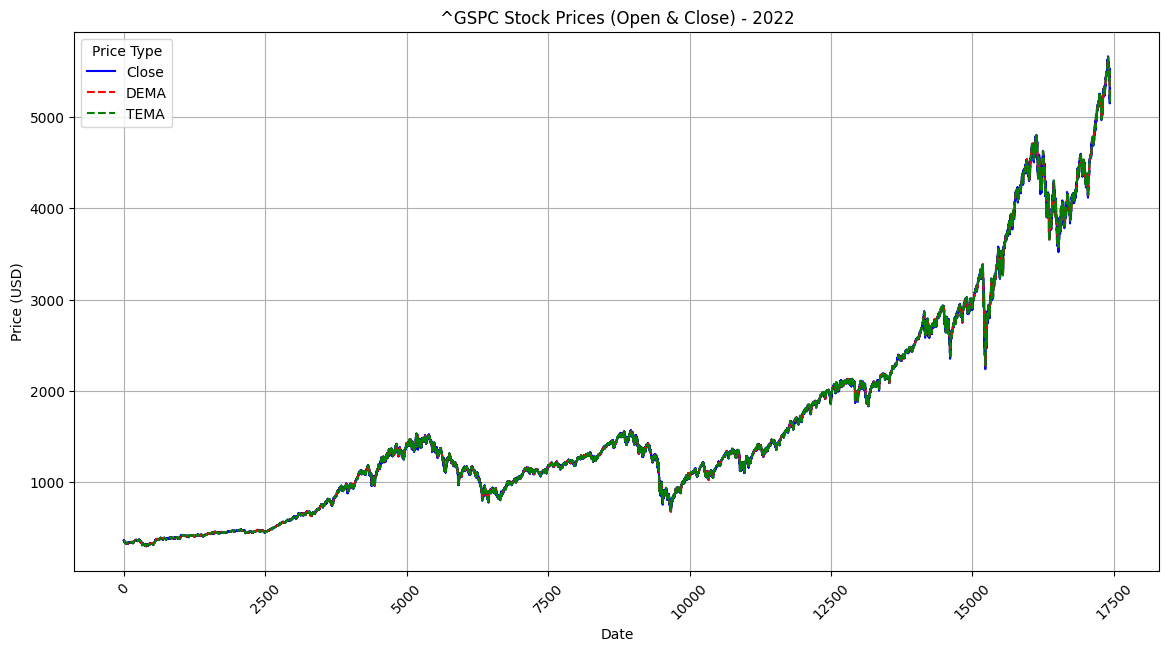

In [42]:

# Combine Open and Close into a single column
combined_data = pd.DataFrame({
    'Date': dataset.index.tolist() * 2,  
    'Price Type': ['Open'] * len(dataset['Open']) + ['Close'] * len(dataset['Close']),
    'Price': pd.concat([dataset['Open'], dataset['Close']], ignore_index=True)
})

# Sort the combined data by Date and Price Type
combined_data_sorted = combined_data.sort_values(
    by=['Date', 'Price Type']).reset_index(drop=True)

price_series = combined_data_sorted['Price']

# Calculate DEMA and TEMA
data01 = calculate_DEMA(price_series, 10)
data02 = calculate_TEMA(price_series, 10)
dataset_input1 = pd.DataFrame({
    'Close': price_series,
    'DEMA': data01,
    'TEMA': data02
})
print(dataset_input1)

plt.figure(figsize=(14, 7))

plt.plot(dataset_input1.index,
         dataset_input1['Close'], label='Close', color='blue')

# Plot DEMA (Double Exponential Moving Average)
plt.plot(dataset_input1.index,
         dataset_input1['DEMA'], label='DEMA', color='red', linestyle='--')

# Plot TEMA (Triple Exponential Moving Average)
plt.plot(dataset_input1.index,
         dataset_input1['TEMA'], label='TEMA', color='green', linestyle='--')

# Customize the plot
plt.title(f"{ticker} Stock Prices (Open & Close) - 2022")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.xticks(rotation=45)
plt.legend(title="Price Type")
plt.grid(True)

# Show the plot
plt.show()

In [37]:
dataset_input1

<bound method DataFrame.sum of                   Close         DEMA         TEMA
Date                                             
1990-01-02   353.399994   353.399994   353.399994
1990-01-03   359.690002   355.479336   356.244911
1990-01-04   358.760010   356.703052   357.703424
1990-01-05   355.670013   356.568746   357.223826
1990-01-08   352.200012   355.302020   355.273994
...                 ...          ...          ...
2024-08-02  5346.560059  5416.142546  5393.531229
2024-08-05  5186.330078  5333.758106  5288.452841
2024-08-06  5240.029785  5291.486507  5245.062796
2024-08-07  5199.500000  5248.089665  5201.272144
2024-08-08  5319.310059  5257.039248  5230.055969

[17434 rows x 3 columns]>

In [43]:
scaler_type = StandardScaler()
# Prepare the ETL instance
data = ETL(
    datainput=dataset_input1,
    test_size=0.1,
    n_input=5,  # Look-back period
    timestep=10,  # Number of past days to use for each prediction
    normalize_bool=True,
    scaler=scaler_type
)

X_train, y_train = data.X_train, data.y_train
X_val, y_val = data.X_test, data.y_test
print(f"X_train shape: {data.X_train.shape}")
print(f"X_test shape: {data.X_test.shape}")
print(f"y_train shape: {data.y_train.shape}")
print(f"y_test shape: {data.y_test.shape}")

train:           Close      DEMA      TEMA
0     -1.091687 -1.091621 -1.091685
1     -1.097023 -1.093385 -1.094098
2     -1.092476 -1.093181 -1.093636
3     -1.091687 -1.092758 -1.092935
4     -1.095097 -1.093564 -1.093988
...         ...       ...       ...
15686  1.923440  1.938231  1.931577
15687  1.925044  1.935526  1.928176
15688  1.917282  1.930797  1.922327
15689  1.929540  1.931233  1.923995
15690  1.891654  1.918940  1.908056

[15691 rows x 3 columns] test:           Close      DEMA      TEMA
15691  1.899332  1.912342  1.901071
15692  1.895786  1.906318  1.895182
15693  1.875172  1.895118  1.882380
15694  1.933162  1.906126  1.900620
15695  1.889287  1.899880  1.893450
...         ...       ...       ...
17429  3.019837  3.029559  2.999346
17430  3.013967  3.012666  2.988182
17431  3.093394  3.027648  3.019571
17432  3.115603  3.047184  3.053017
17433  3.058987  3.043801  3.051335

[1743 rows x 3 columns]
train_transformed shape: (1569, 10, 3)
test_transformed shape: (174, 10,

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [44]:
data.train

array([[[-1.09168686, -1.0916211 , -1.09168478],
        [-1.09702273, -1.0933849 , -1.09409815],
        [-1.09247578, -1.09318068, -1.0936357 ],
        ...,
        [-1.09509706, -1.09512623, -1.09571893],
        [-1.09669188, -1.09579463, -1.09644236],
        [-1.09804069, -1.0967154 , -1.097486  ]],

       [[-1.10022934, -1.09809687, -1.09911479],
        [-1.09665797, -1.09790943, -1.09851434],
        [-1.10218893, -1.09956868, -1.10053973],
        ...,
        [-1.10115399, -1.10370008, -1.10433972],
        [-1.11093499, -1.10650079, -1.10783013],
        [-1.10844945, -1.1076984 , -1.10892229]],

       [[-1.10775384, -1.10829278, -1.10919582],
        [-1.11093499, -1.1097222 , -1.11068125],
        [-1.11059568, -1.11060478, -1.11138748],
        ...,
        [-1.1099255 , -1.11098384, -1.11047028],
        [-1.11655079, -1.11318589, -1.11337725],
        [-1.1091196 , -1.11231257, -1.11188818]],

       ...,

       [[ 1.7540077 ,  1.7985137 ,  1.77784854],
        [ 1

Epoch 1/25


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/layer.py:877: UserWarning: Layer 'query' (of type EinsumDense) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/layer.py:877: UserWarning: Layer 'key' (of type EinsumDense) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/layer.py:877: UserWarning: Layer 'value' (of type EinsumDense) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy th

50/50 ━━━━━━━━━━━━━━━━━━━━ 14s 29ms/step - loss: 0.5219 - mae: 0.5908 - mape: 131.5845 - val_loss: 2.0385 - val_mae: 1.3692 - val_mape: 58.5812
Epoch 2/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.1212 - mae: 0.2621 - mape: 73.8733 - val_loss: 0.0421 - val_mae: 0.1655 - val_mape: 7.0617
Epoch 3/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0713 - mae: 0.2101 - mape: 70.3920 - val_loss: 0.0868 - val_mae: 0.2619 - val_mape: 11.2757
Epoch 4/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0597 - mae: 0.1914 - mape: 64.0298 - val_loss: 0.0321 - val_mae: 0.1529 - val_mape: 6.4807
Epoch 5/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0416 - mae: 0.1561 - mape: 45.8936 - val_loss: 0.0282 - val_mae: 0.1407 - val_mape: 5.9862
Epoch 6/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0358 - mae: 0.1447 - mape: 48.1801 - val_loss: 0.0683 - val_mae: 0.2457 - val_mape: 10.5676
Epoch 7/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0328 - mae: 0.1400 - mape: 77.357

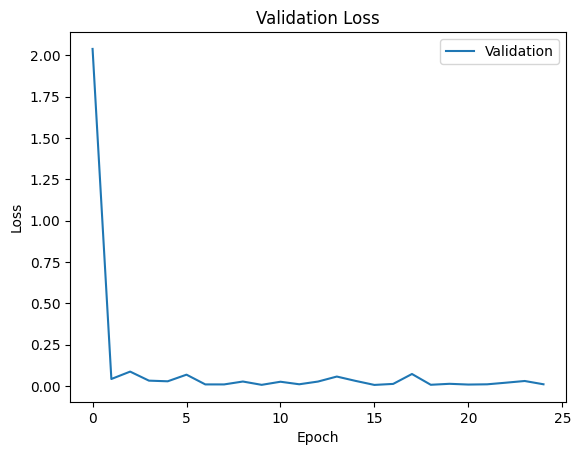

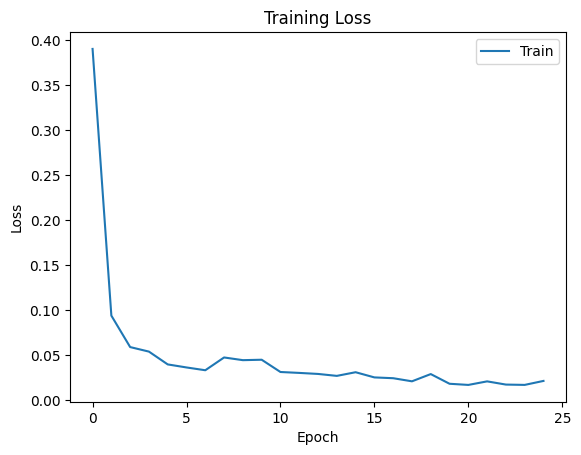

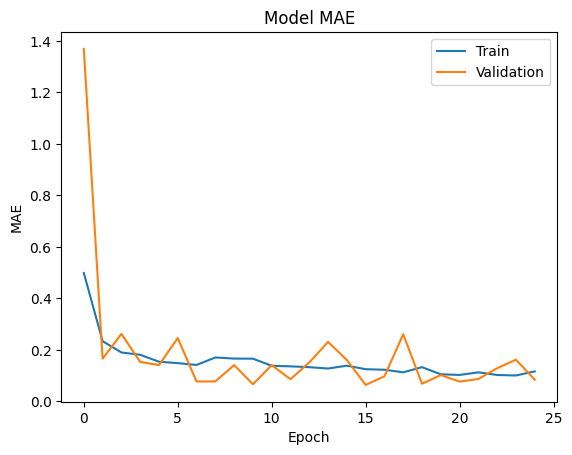

In [45]:
model = build_transformer(head_size=16, num_heads=4,
                          ff_dim=128, num_trans_blocks=12,
                          mlp_units=[64],
                          dropout=0.2, mlp_dropout=0.2)

fit_transformer(model, X_train, y_train, X_val, y_val, display_loss=True)

Predictions shape: (2600, 5, 3)
Predictions shape: (2600, 5, 3)
************************
Initial training series:
0       -1.091687
1       -1.091621
2       -1.091685
3       -1.097023
4       -1.093385
           ...   
23530    1.945220
23531    1.943762
23532    1.938167
23533    1.945796
23534    1.943216
Length: 23535, dtype: float64

train value 0       -1.091687
1       -1.091621
2       -1.091685
3       -1.097023
4       -1.093385
           ...   
23530    1.945220
23531    1.943762
23532    1.938167
23533    1.945796
23534    1.943216
Length: 23535, dtype: float64
origin value 0       1.899332
1       1.912342
2       1.901071
3       1.895786
4       1.906318
          ...   
2605    3.219097
2606    3.216944
2607    3.164228
2608    3.198196
2609    3.190258
Length: 2610, dtype: float64
***********************
Step 1:
Predicted value: 1.9437426755640528
Original value: 1.899331548414153
next prediction:23535    1.943743
Name: pred, dtype: float64
Kalman adjusted predictio

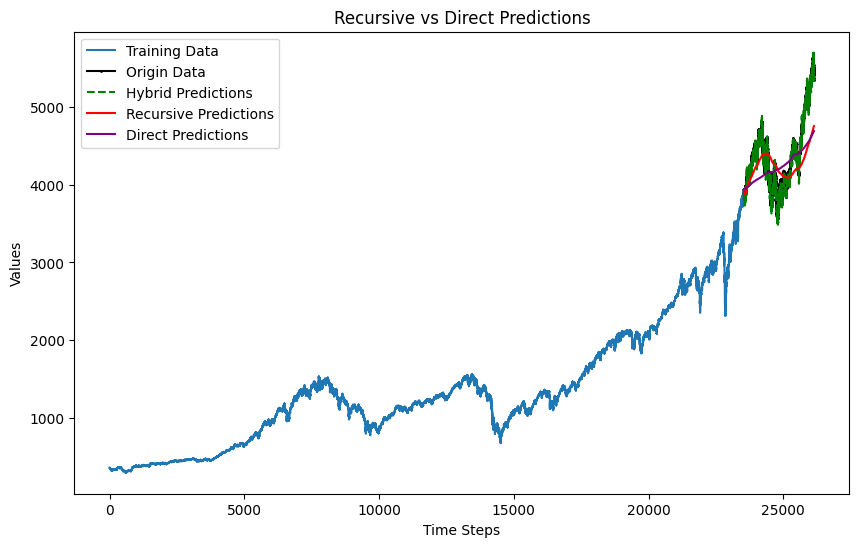

In [75]:
# scaler = StandardScaler()
# train_data = scaler.fit_transform(
#     X_train.reshape(-1, 1)).reshape(X_train.shape)

predict_and_forecast = PredictAndForecast(
    model, X_train, X_val,
    n_input=5
)
step_time_prediction = 2600

predictions = predict_and_forecast.get_predictions(step=step_time_prediction)
print(f'Predictions shape: {predictions.shape}')
predictions = np.array(predictions).flatten()
# predict_and_forecast.plot_predictions(
#     steps=500, preds=predictions, normaliza_bool=True, scaler=scaler_type)
test_series, recursive_preds, direct_preds, hybrid_preds = predict_and_forecast.plot_predictions(
    steps=step_time_prediction, preds=predictions, normaliza_bool=True, scaler=scaler_type)

In [76]:
metrics = predict_and_forecast.evaluate_predictions(
    test_series, recursive_preds, direct_preds, hybrid_preds)
print(metrics)


Recursive Predictions:
MAE: 298.5116250621598
MAPE: 0.0656548051931422
RMSE: 373.12165402091387
R2: 0.3040585155238319

Direct Predictions:
MAE: 315.36373848436193
MAPE: 0.06958181752837767
RMSE: 384.9224464691104
R2: 0.2593410210943481

Hybrid Predictions:
MAE: 92.66953928674002
MAPE: 0.021344157194732937
RMSE: 115.80560386022427
R2: 0.9329604688514942
{'recursive': {'MAE': 298.5116250621598, 'MAPE': 0.0656548051931422, 'RMSE': 373.12165402091387, 'R2': 0.3040585155238319}, 'direct': {'MAE': 315.36373848436193, 'MAPE': 0.06958181752837767, 'RMSE': 384.9224464691104, 'R2': 0.2593410210943481}, 'hybrid': {'MAE': 92.66953928674002, 'MAPE': 0.021344157194732937, 'RMSE': 115.80560386022427, 'R2': 0.9329604688514942}}


************************
Initial training series:
0       -1.091687
1       -1.091621
2       -1.091685
3       -1.097023
4       -1.093385
           ...   
23530    1.945220
23531    1.943762
23532    1.938167
23533    1.945796
23534    1.943216
Length: 23535, dtype: float64

train value 0       -1.091687
1       -1.091621
2       -1.091685
3       -1.097023
4       -1.093385
           ...   
23530    1.945220
23531    1.943762
23532    1.938167
23533    1.945796
23534    1.943216
Length: 23535, dtype: float64
origin value 0       1.899332
1       1.912342
2       1.901071
3       1.895786
4       1.906318
          ...   
2605    3.219097
2606    3.216944
2607    3.164228
2608    3.198196
2609    3.190258
Length: 2610, dtype: float64
***********************
Step 1:
Predicted value: 1.9437426755640528
Original value: 1.899331548414153
next prediction:23535    1.943743
Name: pred, dtype: float64
Step 2:
Predicted value: 1.945071142243247
Original value: 1.9123416279255094
next predic

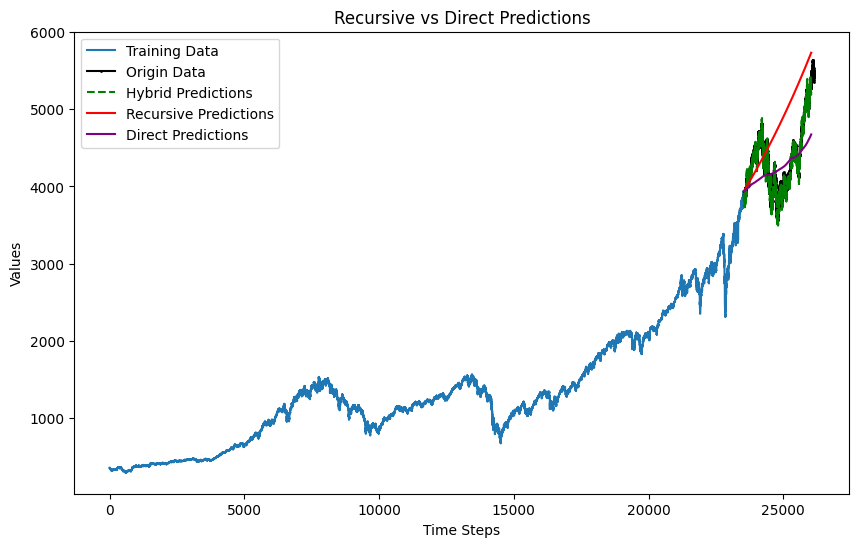

Evaluation Metrics:

Recursive Predictions:
MAE: 548.8231027391835
MAPE: 0.12938612208531222
RMSE: 637.8234705242413
R2: -1.603819975393138

Direct Predictions:
MAE: 288.7306119426377
MAPE: 0.06529045439353255
RMSE: 343.60178657377026
R2: 0.24434982301888186

Hybrid Predictions:
MAE: 92.58340273013766
MAPE: 0.021508858631907445
RMSE: 115.93012449261434
R2: 0.9139793804290124
{'recursive': {'MAE': 548.8231027391835, 'MAPE': 0.12938612208531222, 'RMSE': 637.8234705242413, 'R2': -1.603819975393138}, 'direct': {'MAE': 288.7306119426377, 'MAPE': 0.06529045439353255, 'RMSE': 343.60178657377026, 'R2': 0.24434982301888186}, 'hybrid': {'MAE': 92.58340273013766, 'MAPE': 0.021508858631907445, 'RMSE': 115.93012449261434, 'R2': 0.9139793804290124}}


In [63]:
test_series, recursive_preds, direct_preds, hybrid_preds = predict_and_forecast.plot_predictions(
    steps=step_time_prediction, preds=predictions, normaliza_bool=True, scaler=scaler_type, tracker_active=False)
metrics = predict_and_forecast.evaluate_predictions(
    test_series, recursive_preds, direct_preds, hybrid_preds)
print(metrics)

In [ ]:
from tensorflow.keras import layers, models, optimizers, losses


def train_transformer(model, x_train, y_train, x_val, y_val, epochs=50, batch_size=32):
    optimizer = optimizers.Adam(learning_rate=1e-4)
    loss_fn = losses.MeanSquaredError()

    train_dataset = tf.data.Dataset.from_tensor_slices(
        (x_train, y_train)).batch(batch_size)
    val_dataset = tf.data.Dataset.from_tensor_slices(
        (x_val, y_val)).batch(batch_size)

    for epoch in range(epochs):
        print(f"Epoch {epoch + 1}/{epochs}")
        # Training loop
        for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):
            with tf.GradientTape() as tape:
                predictions = model(x_batch_train, training=True)
                loss = loss_fn(y_batch_train, predictions)

            gradients = tape.gradient(loss, model.trainable_weights)
            optimizer.apply_gradients(zip(gradients, model.trainable_weights))

            if step % 100 == 0:
                print(f"Training loss at step {step}: {loss.numpy()}")

        # Validation loop
        val_loss = []
        for x_batch_val, y_batch_val in val_dataset:
            val_predictions = model(x_batch_val, training=False)
            val_loss.append(loss_fn(y_batch_val, val_predictions).numpy())

        print(f"Validation loss: {np.mean(val_loss)}")


def plot_results(train, test, preds, df, normalize_bool, scaler, title_suffix=None, xlabel='AAPL stock Price'):
    """
    Plots training data in blue, actual values in red, and predictions in green,
    over time.
    """

    fig, ax = plt.subplots(figsize=(20, 6))
    if not isinstance(df, pd.DataFrame):
        df = pd.DataFrame(df)
    # x = df.Close[-498:].index
    plot_test = test[1:]
    plot_preds = preds[1:]
    if normalize_bool == True:
        # Inverse transform to get back to original scale
        plot_test = scaler.inverse_transform(
            plot_test.reshape(-1, 1)).reshape(plot_test.shape)
        train = scaler.inverse_transform(
            train.reshape(-1, 1)).reshape(train.shape)
        plot_preds = scaler.inverse_transform(
            plot_preds.reshape(-1, 1)).reshape(plot_preds.shape)
        print("normalization convert active")

    # x = df[-(plot_test.shape[0]*plot_test.shape[1]):].index
    plot_test = plot_test.reshape((plot_test.shape[0]*plot_test.shape[1], 1))
    plot_preds = plot_preds.reshape((plot_test.shape[0]*plot_test.shape[1], 1))
    plot_train = train.reshape((train.shape[0]*train.shape[1], 1))
    print(f'plot_train shape: {plot_train.shape}')
    print(f'plot_test shape: {plot_test.shape}')
    print(f'plot_preds shape: {plot_preds.shape}')

    x_train = df[:len(plot_train)].index
    x_test = df[len(plot_train):len(plot_train) + len(plot_test)].index

    ax.plot(x_train, plot_train, label='Train', color='blue')
    ax.plot(x_test, plot_test, label='actual', color='red')
    ax.plot(x_test, plot_preds, label='preds', color='green')
    if title_suffix == None:
        ax.set_title('Predictions vs. Actual')
    else:
        ax.set_title(f'Predictions vs. Actual, {title_suffix}')
    ax.set_xlabel('Date')
    ax.set_ylabel(xlabel)
    ax.legend()
    plt.show()


train_transformer(model, X_train, y_train, X_val, y_val)

NameError: name 'model' is not defined